Import all the libraries required for this notebook

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import requests
import io
import urllib.parse
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import functools
from PIL import Image  # Image utilities.
import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import imageio as io_temp
from skimage.transform import resize
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix


cudnn.benchmark = True
plt.ion()   # interactive mode

Downloading the dataset from online resources

In [2]:
SOURCE_URL = 'https://storage.googleapis.com/dm-turtle-recall/images.tar'
IMAGE_DIR = './turtle_recall/images'
TAR_PATH = os.path.join(IMAGE_DIR, os.path.basename(SOURCE_URL))
EXPECTED_IMAGE_COUNT = 13891

%sx mkdir --parents "{IMAGE_DIR}"
if len(os.listdir(IMAGE_DIR)) != EXPECTED_IMAGE_COUNT:
  %sx wget --no-check-certificate -O "{TAR_PATH}" "{SOURCE_URL}"
  %sx tar --extract --file="{TAR_PATH}" --directory="{IMAGE_DIR}"
  %sx rm "{TAR_PATH}"

print(f'The total number of images is: {len(os.listdir(IMAGE_DIR))}')

The total number of images is: 13891


In [3]:
BASE_URL = 'https://storage.googleapis.com/dm-turtle-recall/'


def read_csv_from_web(file_name):
  url = urllib.parse.urljoin(BASE_URL, file_name)
  content = requests.get(url).content
  return pd.read_csv(io.StringIO(content.decode('utf-8')))

# Read in csv files.
train = read_csv_from_web('train.csv')
test = read_csv_from_web('test.csv')
extra = read_csv_from_web('extra_images.csv')
sample_submission = read_csv_from_web('sample_submission.csv')

# Convert image_location strings to lowercase.
for df in [train, test]:
  df.image_location = df.image_location.apply(lambda x: x.lower())
  assert set(df.image_location.unique()) == set(['left', 'right', 'top'])

In [4]:
train.head()

,image_id,image_location,turtle_id
0,ID_2RK4WLN8,top,t_id_VP2NW7aV
1,ID_VVW0QXLX,left,t_id_qZ0iZYsC
2,ID_RVATH2HZ,right,t_id_3b65X5Lw
3,ID_2GB90GPS,left,t_id_YjXYTCGC
4,ID_LM6S0B1M,top,t_id_d6aYXtor


In [5]:
test.head()

,image_id,image_location
0,ID_6NEDKOYZ,top
1,ID_57QZ4S9N,left
2,ID_OCGGJS5X,left
3,ID_R2993S3S,top
4,ID_2E011NB0,left


In [6]:
extra.head()

,image_id,turtle_id
0,ID_Y0KYE5XD,t_id_he7JTQxO
1,ID_8JTIQ4UI,t_id_he7JTQxO
2,ID_LSXPZYSN,t_id_he7JTQxO
3,ID_SHZ2HDSP,t_id_he7JTQxO
4,ID_6TOFB06E,t_id_xry0Yg2j


In [7]:
train.shape, test.shape, extra.shape

((2145, 3), (490, 2), (10658, 2))

In [8]:
print(f"There are {train.turtle_id.nunique()} unique turtles in the train set.")
print(f"There are {extra.turtle_id.nunique()} unique turtles in the train set.")

There are 100 unique turtles in the train set.
There are 2231 unique turtles in the train set.


In [9]:
train_images_per_turtle = pd.value_counts(train['turtle_id'])
extra_images_per_turtle = pd.value_counts(extra['turtle_id'])

In [10]:
train_images_per_turtle

t_id_ROFhVsy2    77
t_id_hRzOoJ2t    68
t_id_VP2NW7aV    58
t_id_Kf73l69A    57
t_id_dVQ4x3wz    47
                 ..
t_id_Dv4O8bOM    10
t_id_4XiPKIk7    10
t_id_OqU1NWEA     9
t_id_p77GDtzg     9
t_id_J5dngbNA     8
Name: turtle_id, Length: 100, dtype: int64

In [11]:
extra_images_per_turtle

t_id_dVQ4x3wz    68
t_id_UkwhEKp2    41
t_id_YjXYTCGC    40
t_id_XN39nRhf    40
t_id_FFUgltSC    37
                 ..
t_id_31E0Dcfq     1
t_id_wITmkTkm     1
t_id_2Yn71r7R     1
t_id_1Lr4vRbM     1
t_id_DbmclTcj     1
Name: turtle_id, Length: 2231, dtype: int64

Capturing all the turtle IDs and assigning a number to each turtle

In [12]:
ls = pd.unique(train['turtle_id'])
classes = {}
for i in range(len(ls)):
    classes[ls[i]] = i
class_names = classes
ls2 = pd.unique(train['image_location'])
locations = {}
for i in range(len(ls2)):
    locations[ls2[i]] = i

In [13]:
num_classes = len(class_names)
num_locations = len(['left', 'right', 'top'])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train[['image_id','image_location']], train['turtle_id'], test_size=0.20, random_state=42, stratify=train['turtle_id'])
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=42, stratify=y_test)

print(X_train.shape, X_test.shape, X_val.shape ,y_train.shape, y_test.shape, y_val.shape)

train_ds = pd.concat([X_train, y_train], axis=1)
train_ds['type'] = "train"
test_ds = pd.concat([X_test, y_test], axis=1)
test_ds['type'] = "test"
val_ds = pd.concat([X_val, y_val], axis=1)
val_ds['type'] = "val"
extra_ds = extra
extra_ds['type'] = "extra"

(1716, 2) (214, 2) (215, 2) (1716,) (214,) (215,)


In [15]:
dataset_sizes = {'train': len(train_ds), 'test': len(test_ds), 'val': len(val_ds), 'extra': len(extra_ds)}

In [16]:
train_ds

,image_id,image_location,turtle_id,type
708,ID_UC0NFKIH,left,t_id_UVQa4BMz,train
59,ID_IZB1O90H,right,t_id_2QmcRkNj,train
614,ID_L4O6H0WC,top,t_id_8b8sprYe,train
2011,ID_BUYIHPE9,left,t_id_tjWepji1,train
761,ID_2HBGMZLT,right,t_id_BI99coHt,train
...,...,...,...,...
1126,ID_3JHL0XDW,left,t_id_AOWArhGb,train
697,ID_DBYS9YUA,right,t_id_uJXT7dGu,train
165,ID_XAO3YF62,top,t_id_D0gA44av,train
52,ID_P7LXRA4M,left,t_id_4XiPKIk7,train


In [17]:
extra_ds

,image_id,turtle_id,type
0,ID_Y0KYE5XD,t_id_he7JTQxO,extra
1,ID_8JTIQ4UI,t_id_he7JTQxO,extra
2,ID_LSXPZYSN,t_id_he7JTQxO,extra
3,ID_SHZ2HDSP,t_id_he7JTQxO,extra
4,ID_6TOFB06E,t_id_xry0Yg2j,extra
...,...,...,...
10653,ID_PLYDY39S,t_id_9YXAIhtI,extra
10654,ID_1EJCP0DF,t_id_9YXAIhtI,extra
10655,ID_WXIGYROR,t_id_ajlHbN2F,extra
10656,ID_UAU4GUNK,t_id_ajlHbN2F,extra


In [18]:
dataset = pd.concat([train_ds,test_ds,val_ds,extra_ds], axis=0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [19]:
dataset

,image_id,image_location,turtle_id,type
708,ID_UC0NFKIH,left,t_id_UVQa4BMz,train
59,ID_IZB1O90H,right,t_id_2QmcRkNj,train
614,ID_L4O6H0WC,top,t_id_8b8sprYe,train
2011,ID_BUYIHPE9,left,t_id_tjWepji1,train
761,ID_2HBGMZLT,right,t_id_BI99coHt,train
...,...,...,...,...
10653,ID_PLYDY39S,NaN,t_id_9YXAIhtI,extra
10654,ID_1EJCP0DF,NaN,t_id_9YXAIhtI,extra
10655,ID_WXIGYROR,NaN,t_id_ajlHbN2F,extra
10656,ID_UAU4GUNK,NaN,t_id_ajlHbN2F,extra


In [20]:
dataset['image_id'] = IMAGE_DIR + "/" + dataset['image_id'].astype(str) + ".JPG"

Replacing the turtle IDs with numbers for easier training by the deep learning model

In [21]:
dataset['turtle_id'] = dataset['turtle_id'].map(classes)
dataset['image_location'] = dataset['image_location'].map(locations)

In [22]:
dataset.to_csv('./dataset.csv')

In [23]:
train_ds = dataset.loc[dataset['type'] == "train"]
test_ds = dataset.loc[dataset['type'] == "test"]
val_ds = dataset.loc[dataset['type'] == "val"]
extra_ds = dataset.loc[dataset['type'] == "extra"]

In [24]:
train_ds

,image_id,image_location,turtle_id,type
708,./turtle_recall/images/ID_UC0NFKIH.JPG,1.0,37.0,train
59,./turtle_recall/images/ID_IZB1O90H.JPG,2.0,44.0,train
614,./turtle_recall/images/ID_L4O6H0WC.JPG,0.0,43.0,train
2011,./turtle_recall/images/ID_BUYIHPE9.JPG,1.0,38.0,train
761,./turtle_recall/images/ID_2HBGMZLT.JPG,2.0,23.0,train
...,...,...,...,...
1126,./turtle_recall/images/ID_3JHL0XDW.JPG,1.0,25.0,train
697,./turtle_recall/images/ID_DBYS9YUA.JPG,2.0,54.0,train
165,./turtle_recall/images/ID_XAO3YF62.JPG,0.0,63.0,train
52,./turtle_recall/images/ID_P7LXRA4M.JPG,1.0,26.0,train


In [25]:
extra_ds

,image_id,image_location,turtle_id,type
0,./turtle_recall/images/ID_Y0KYE5XD.JPG,NaN,NaN,extra
1,./turtle_recall/images/ID_8JTIQ4UI.JPG,NaN,NaN,extra
2,./turtle_recall/images/ID_LSXPZYSN.JPG,NaN,NaN,extra
3,./turtle_recall/images/ID_SHZ2HDSP.JPG,NaN,NaN,extra
4,./turtle_recall/images/ID_6TOFB06E.JPG,NaN,NaN,extra
...,...,...,...,...
10653,./turtle_recall/images/ID_PLYDY39S.JPG,NaN,NaN,extra
10654,./turtle_recall/images/ID_1EJCP0DF.JPG,NaN,NaN,extra
10655,./turtle_recall/images/ID_WXIGYROR.JPG,NaN,NaN,extra
10656,./turtle_recall/images/ID_UAU4GUNK.JPG,NaN,NaN,extra


Creating a Dataloader for our dataset which can be used for pytorch. This only makes use of the image data and the turtle ID. The turtles head orientation is not used

In [97]:
class TurtleDataset(Dataset):
    """Turtle dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.csv.iloc[idx, 0]
        image = io_temp.imread(img_name)
        details = self.csv.iloc[idx, 1:]
        details = np.array([details])
        details = details[:1]
        sample = {'image': image, 'image_orientation': details[0][0], 'turtle_id': details[0][1], 'image_id': img_name}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [98]:
def show_pics(image, image_orientation, turtle_id):
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated


0 (743, 876, 3) 37.0 1.0


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fd963abf9b0>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/opt/conda/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


TypeError: show_pics() got an unexpected keyword argument 'image_id'

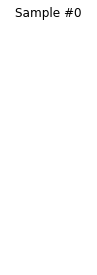

In [99]:
face_dataset = TurtleDataset(csv_file=train_ds)

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['turtle_id'], sample['image_orientation'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_pics(**sample)

    if i == 3:
        plt.show()
        break

Rescale helps reformat the image by changing its dimensions and cropping it to allow it to be used as an input in our model

In [100]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size = 224):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        #image, turtle_id = sample['image'], sample['image_orientation']#,  sample['turtle_id'] 
        image, image_orientation = sample['image'], sample['image_orientation']

        h, w = image.shape[:2]
        crop_size = min(w, h)
        crop = image[(h - crop_size) // 2 : (h + crop_size) // 2, (w - crop_size) // 2 : (w + crop_size) // 2]
        img = resize(crop, (self.output_size, self.output_size))

        # return {'image': img, 'turtle_id': turtle_id}
        #return [img.transpose((2,0,1)).astype(np.double),turtle_id]
        return [img.transpose((2,0,1)).astype(np.double),image_orientation]

In [101]:
class Rescale_extra(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size = 224):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        #image, turtle_id = sample['image'], sample['image_orientation']#,  sample['turtle_id'] 
        image, image_orientation = sample['image'], sample['image_id']

        h, w = image.shape[:2]
        crop_size = min(w, h)
        crop = image[(h - crop_size) // 2 : (h + crop_size) // 2, (w - crop_size) // 2 : (w + crop_size) // 2]
        img = resize(crop, (self.output_size, self.output_size))

        # return {'image': img, 'turtle_id': turtle_id}
        #return [img.transpose((2,0,1)).astype(np.double),turtle_id]
        return [img.transpose((2,0,1)).astype(np.double),image_orientation]

In [102]:
scale = Rescale(256)

In [103]:
train_transformed_dataset = TurtleDataset(csv_file=train_ds,
                                               transform=transforms.Compose([
                                               Rescale(256)
                                           ]))
test_transformed_dataset = TurtleDataset(csv_file=test_ds,
                                               transform=transforms.Compose([
                                               Rescale(256)
                                           ]))
val_transformed_dataset = TurtleDataset(csv_file=val_ds,
                                               transform=transforms.Compose([
                                               Rescale(256)
                                           ]))
extra_transformed_dataset = TurtleDataset(csv_file=extra_ds,
                                              transform=transforms.Compose([
                                              Rescale_extra(256)
                                           ]))

In [85]:
dataloaders = {#'train' : DataLoader(train_transformed_dataset, batch_size=16,
#                         shuffle=True, num_workers=2),
              'test' : DataLoader(test_transformed_dataset, batch_size=16,
                        shuffle=True, num_workers=2),
#               'val' : DataLoader(val_transformed_dataset, batch_size=16,
#                         shuffle=True, num_workers=2),
              'extra': DataLoader(extra_transformed_dataset, batch_size=16,
                        shuffle=True, num_workers=2)}


In [34]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=classes)

KeyError: 'train'

train_model is a funciton to train any model with any criterion and optimizer. We can change the model input with other pretrained models to experiment further!

In [35]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #inputs = inputs.type(torch.LongTensor)
                inputs = inputs.to(device)
                labels = labels.type(torch.LongTensor)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [36]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs.float())
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [38]:
device

device(type='cuda', index=0)

In [40]:
model_ft = models.resnet18(pretrained=True, progress=True) ### Can change this to try out other models available 
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, num_locations)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [45]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=4)

Epoch 0/3
----------
train Loss: 0.5039 Acc: 0.8024
val Loss: 0.2317 Acc: 0.9302

Epoch 1/3
----------
train Loss: 0.2036 Acc: 0.9359
val Loss: 0.2220 Acc: 0.9256

Epoch 2/3
----------
train Loss: 0.1159 Acc: 0.9645
val Loss: 0.2334 Acc: 0.9349

Epoch 3/3
----------
train Loss: 0.0666 Acc: 0.9843
val Loss: 0.2320 Acc: 0.9488

Training complete in 15m 38s
Best val Acc: 0.948837


In [53]:
# torch.save(model_ft.state_dict(),"turtle_image_location.pth")

In [48]:
model = models.resnet18(pretrained=True, progress=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, num_locations)
model.load_state_dict(torch.load("turtle_image_location.pth"))
model.eval()
model_ft = model.to(device)

In [49]:
def apk(actual, predicted, k=5):
  """Computes the average precision at k.

  Args:
    actual: The turtle ID to be predicted.
    predicted : A list of predicted turtle IDs (order does matter).
    k : The maximum number of predicted elements.

  Returns:
    The average precision at k.
  """
  if len(predicted) > k:
    predicted = predicted[:k]

  score = 0.0
  num_hits = 0.0

  for i, p in enumerate(predicted):
    if p == actual and p not in predicted[:i]:
      num_hits += 1.0
      score += num_hits / (i + 1.0)

  return score


def mapk(actual, predicted, k=5):
  """ Computes the mean average precision at k.

    The turtle ID at actual[i] will be used to score predicted[i][:k] so order
    matters throughout!

    actual: A list of the true turtle IDs to score against.
    predicted: A list of lists of predicted turtle IDs.
    k: The size of the window to score within.

    Returns:
      The mean average precision at k.
  """
  return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

In [52]:
def test_model(model, criterion, optimizer, scheduler):

    model.eval()   # Set model to evaluate mode

    t_output = []
    t_pred = []
    y_test = []
    top_k = []
    # Iterate over data.
    for inputs, labels in dataloaders['test']:
        # inputs = inputs.type(torch.DoubleTensor)
        inputs = inputs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        y_test.append(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(True):
            outputs = model(inputs.float())
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            t_output.append(outputs)
            t_pred.append(preds)
            temp1, temp2 = outputs.topk(1)
            top_k.append(temp2)
    
    y_test = torch.cat(y_test).cpu().detach().numpy() 
    y_test_num = torch.cat(t_pred).cpu().detach().numpy() 
    y_pred = torch.cat(top_k).cpu().detach().numpy() 
    mapk_result = mapk(y_test, y_pred, k=1)
    print("With real set labels, our mapk with k=1 is", mapk_result)
    print('\nConfusion Matrix')
    conf_mt = confusion_matrix(y_test_num, y_test)
    print(conf_mt)
    plt.matshow(conf_mt)
    plt.show()
    print('\nClassification Report')
    print(classification_report(y_test_num, y_test))

With real set labels, our mapk with k=5 is 0.9299065420560748

Confusion Matrix
[[65  2  1]
 [ 2 65  1]
 [ 5  4 69]]


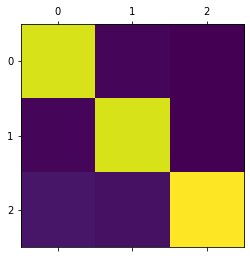


Classification Report
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        68
           1       0.92      0.96      0.94        68
           2       0.97      0.88      0.93        78

    accuracy                           0.93       214
   macro avg       0.93      0.93      0.93       214
weighted avg       0.93      0.93      0.93       214



In [51]:
test_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

In [133]:
def pred(model, criterion, optimizer, scheduler):

    model.eval()   # Set model to evaluate mode

    t_id = []
    t_pred = []
    y_test = []
    top_k = []
    # Iterate over data.
    for inputs,labels in DataLoader(extra_transformed_dataset, batch_size=16, shuffle=True, num_workers=2):
        # inputs = inputs.type(torch.DoubleTensor)
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(True):
            outputs = model(inputs.float())
            _, preds = torch.max(outputs, 1)
            t_id += labels
            t_pred += preds.tolist()


    return t_pred,t_id

In [134]:
y_pred, y_id = pred(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

In [145]:
import pandas as pd
df = pd.DataFrame({"image_id" : y_id, "image_orientation" : y_pred})

In [148]:
df.to_csv("predicted_head_orientation.csv")

In [75]:
# import pickle
# with open("nice.pickle", 'wb') as f:
#     pickle.dump(y_pred, f)